In [15]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

In [16]:
'''Sovling for eccentricity'''
smass = 1.0 #in Solar Mass units
jmass = 0.000954588 #Jupiter Mass in Solar Mass units
e = Symbol('e')
e = solve(2.40*(2.0*jmass)**(1./3.) - (((8./3.)*(e**2 + e**2) + 9*(jmass)**(2./3.)))**(1./2.), e)
if len(e) == 2:
    e = e[1]
    print(f"Eccentricity: {e}")
else:
    e = e[0]
    print(f"Eccentricity: {e}")

Eccentricity: 0.0161470323464714


In [57]:
delta_critical1 = (((8./3.)*(e**2) + 9*(jmass)**(2./3.)))**(1./2.)
delta_critical2 = 2.40*(2.0*jmass)**(1./3.)
print(delta_critical1 + 1.0)

1.29656281119106


In [67]:
'''Set-Up Initial Conditions'''
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','au','solarmass')
    hill_radius = 1.0*(1-e)*(jmass / (3.0 * smass))**(1.0/3.0)
    sim.add(m = smass)
    sim.add(m = jmass, a= 1.0, e = e, r = (0.000477895), f = 0)
    sim.add(m = jmass, a= 1.0 + delta_critical1, e= 0,  r = (0.000477895/2), f = np.pi)
    sim.move_to_com()
    return sim

3 particles in the simulation at t = 0.0 yr
Protoplanet 1 Semi-Major Axis: 1.0000000000000002 AU
Protoplanet 2 Semi-Major Axis: 1.2965628111910628 AU
Period of Protoplanet 1: 0.9995419250229016 yr
Period of Protoplanet 2: 1.4749740048795856 yr
Argument of Periapsis of Protoplanet 1: 0.0 radians
Argument of Periapsis of Protoplanet 2: 1.5707963267948966 radians


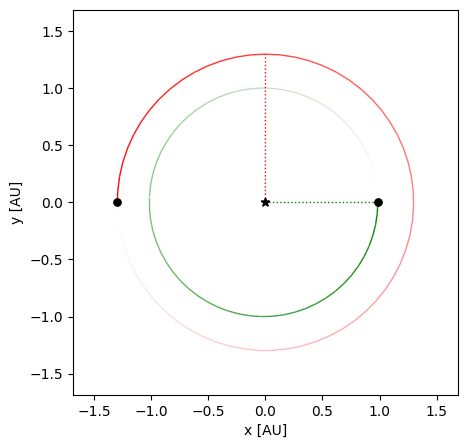

In [68]:
'''Conditions before collision'''
sim = setupSimulation()
tmax = 1e5

period1 = np.array([i.P for i in sim.calculate_orbits()])
omega1 = np.array([i.omega for i in sim.calculate_orbits()])
p1 = period1[0]
p2 = period1[1]
w1 = omega1[0]
w2 = omega1[1]

print(f'{sim.N} particles in the simulation at t = {sim.t} yr')
print(f"Protoplanet 1 Semi-Major Axis: {sim.calculate_orbits()[0].a} AU")
print(f"Protoplanet 2 Semi-Major Axis: {sim.calculate_orbits()[1].a} AU")
print(f'Period of Protoplanet 1: {p1} yr')
print(f'Period of Protoplanet 2: {p2} yr')
print(f"Argument of Periapsis of Protoplanet 1: {w1} radians")
print(f"Argument of Periapsis of Protoplanet 2: {w2} radians")

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [69]:
'''Collision Resolve Function to count the number of close encounters'''
def close_encounter(sim_pointer, collision):
    global count
    global temp
    sim = sim_pointer.contents
    temp = temp + 1
    count = np.append(count, temp)
    return 0

In [70]:
sim = setupSimulation()
temp = 0
count = np.array([0])
sim.collision = "direct"
sim.collision_resolve = close_encounter
sim.integrate(77)
print(f"Number of Close Encounters: {count}")
display(sim.getWidget())

Number of Close Encounters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]


Widget(N=3, count=2, height=200.0, orbit_data=b'R\x19\x10;\x13\xdd\x9e\xb9\x00\x00\x00\x00\xca\xed\xa3?\xdb:a=…

In [55]:
def my_merge(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents 
    ps = sim.particles 

    i = collided_particles_index.p1  
    j = collided_particles_index.p2 

    fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)
    print(f"First Collision Occurs at time: {sim.t} yr")

    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass 
    merged_radius = (ps[i].r**3 + ps[j].r**3)**(1/3)

    ps[i] = merged_planet   
    ps[i].m = total_mass    
    ps[i].r = merged_radius 

    return 2

First Collision Occurs at time: 76.39659476050748 yr
Period of Merged Protoplanet: 1.2239853326548282 yr
Eccentricity of Merged Protoplanet: 0.022267543252523173


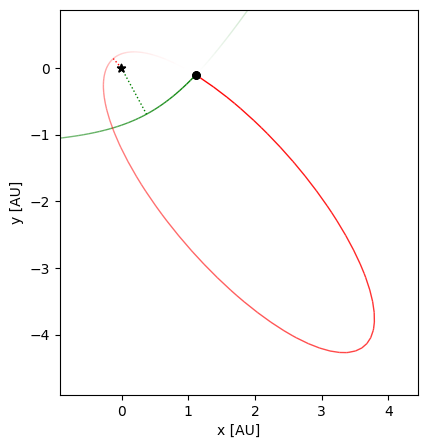

In [56]:
'''Merge Condition'''
sim = setupSimulation()
sim.collision = 'direct'
sim.collision_resolve = my_merge
sim.integrate(tmax)

period2 = np.array([i.P for i in sim.calculate_orbits()])
eccentricity = np.array([i.e for i in sim.calculate_orbits()])

print(f'Period of Merged Protoplanet: {period2[0]} yr')
print(f"Eccentricity of Merged Protoplanet: {eccentricity[0]}")